# CHILI Challenge

### Chemically-Informed Large-scale Inorganic Nano-materials Dataset for Advancing Graph Machine Learning

* New (unpublished) dataset for materials design
* Predict crystal type, from the structure
* $g_\theta(\cdot): G \rightarrow Y$
* Node features: $G_i: (X_i \in \mathbb{R}^{N_i\times F}, A_i \in \{0,1\}^{N_i\times N_i})$
* crystal_type: $Y = [0,1]^{C}$
* Crystal types belong to ['AntiFluorite', 'CadmiumChloride', 'CadmiumIodide', 'CaesiumChloride', 'Fluorite', 'NickelArsenide', 'RheniumTrioxide',
       'RockSalt', 'Rutile', 'Spinel', 'Wurtzite', 'ZincBlende']
  
  ![Crystal Types](crystal_type.png "Target Crystal Types")
  

In [1]:
### Get dataset
from torch_geometric.data import download_url, extract_zip
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from pathlib import Path
import torch
import os
from torch_geometric.seed import seed_everything
from torcheval.metrics import MulticlassF1Score, MulticlassAccuracy
import torch.nn.functional as F
import torch.nn as nn
import pdb
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Download the preprocessd data
* Data is stored on a remote server
* Download it, unzip it!
* This has to be done only once!!!

In [2]:
data_loc = './Data'
if not Path(data_loc).exists():
    Path(data_loc).mkdir()
else:
    print(data_loc, 'exists!')

./Data exists!


In [3]:
save_dir = './Results'
if not Path(save_dir).exists():
    Path(save_dir).mkdir()
else:
    print(save_dir, 'exists!')

./Results exists!


In [4]:
url = 'https://sid.erda.dk/share_redirect/h7plnJoaYR/CHILI-Challenge.zip'
# path = download_url(url,)
dataset_name = 'CHILI-Challenge'

In [5]:
if not Path(data_loc+'/'+dataset_name+'.zip').exists():
    print('Data not locally found. Downloading...')
    path = download_url(url,data_loc)
    print('Extracting data...')
    extract_zip(path, data_loc)
    print('Done!')
else:
    print('Data found at '+data_loc)
    data_loc += '/'+dataset_name
    print(os.listdir(data_loc))

Data found at ./Data
['valid.pt', 'train.pt', 'test.pt']


## Load the processed data and investigate

In [6]:
train_set = torch.load(data_loc+'/train.pt')
valid_set = torch.load(data_loc+'/valid.pt')
test_set = torch.load(data_loc+'/test.pt')

In [7]:
nTrain = len(train_set)
nValid = len(valid_set)
nTest = len(test_set)
print('nTrain: %d, nValid: %d, nTest: %d'%(nTrain,nValid,nTest))

nTrain: 2544, nValid: 318, nTest: 318


In [8]:
# Visualize the data point 
sample = train_set[2]
print(sample)

Data(
  x=[119, 4],
  edge_index=[2, 340],
  edge_attr=[340],
  y={
    crystal_type='Spinel',
    crystal_type_number=9,
  },
  pos_frac=[119, 3],
  pos_abs=[119, 3],
  id='data_100'
)


In [9]:
# print(sample.edge_attr)


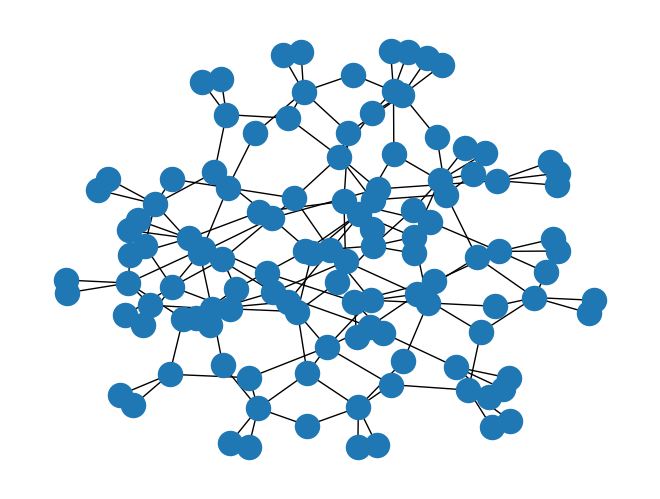

In [10]:
# Basic visualization using networkx
# for more accurate visualization check out https://jp-minerals.org/vesta/en/download.html
import networkx as nx
g = to_networkx(sample, to_undirected=True)
nx.draw(g)

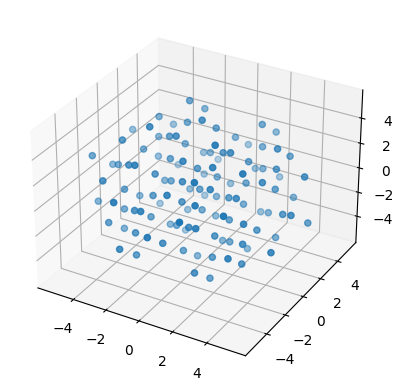

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(sample.pos_abs[:,0],sample.pos_abs[:,1],sample.pos_abs[:,2])

In [12]:
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: pytorch-lightning 1.6.4 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [13]:
#Class distributions
train_labels = np.array([d.y['crystal_type'] for d in train_set])
crystal_types = np.unique(train_labels)
crystal_type_count = np.array([sum(train_labels==c) for c in crystal_types])
distribution = crystal_type_count/nTrain

<BarContainer object of 12 artists>

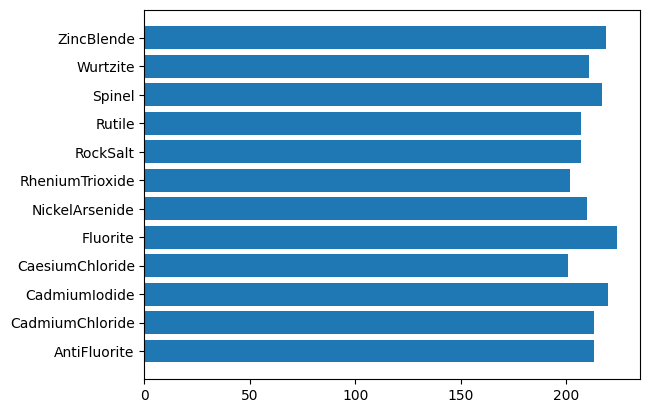

In [14]:
plt.barh(crystal_types,crystal_type_count)

Min. num of nodes: 7
Max. num of nodes: 14793
Mean num of nodes: 2191
Median num of nodes: 1377


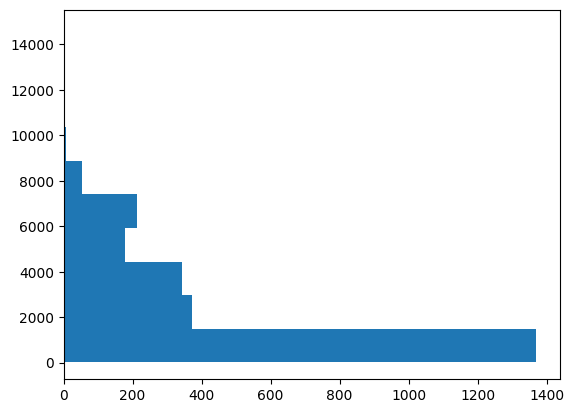

In [15]:
#Num node distributions
train_nodes = [d.x.shape[0] for d in train_set]
plt.hist(train_nodes,orientation='horizontal')
print('Min. num of nodes: %d'%(np.min(train_nodes)))
print('Max. num of nodes: %d'%(np.max(train_nodes)))
print('Mean num of nodes: %d'%(np.mean(train_nodes)))
print('Median num of nodes: %d'%(np.median(train_nodes)))

## Simple basline is to randomly guess the labels
Let us implement a random guessing baseline based on training set distribution

In [16]:
test_set[0]

Data(
  x=[423, 4],
  edge_index=[2, 2792],
  edge_attr=[2792],
  y={
    crystal_type='',
    crystal_type_number=-1,
  },
  pos_frac=[423, 3],
  pos_abs=[423, 3],
  id='data_0'
)

In [17]:
# Random guessing baseline
valid_labels_rand = torch.Tensor(np.random.choice(np.arange(0, 12), size=318, p=distribution))
valid_labels = torch.Tensor(([d.y['crystal_type_number'] for d in valid_set]))

In [18]:
val_acc = sum(valid_labels_rand == valid_labels)/nValid
print(val_acc)

tensor(0.0660)


## Another baseline method using GCNs
* Don't be disappointed if it does not do better than random

In [19]:
### Make a pytorch-geometric dataloader
B = 16
train_loader = DataLoader(train_set,batch_size=B)
valid_loader = DataLoader(valid_set,batch_size=B)
test_loader = DataLoader(test_set,batch_size=B)

In [20]:
### Load GCN model from pyg
from torch_geometric.nn.models import GCN, PMLP
from torch_geometric.nn import global_mean_pool, Linear, global_add_pool, global_max_pool

In [21]:
num_epochs = 50
lr = 1e-3
n_classes = len(crystal_types)

In [22]:
# Define the Graph Neural Network model
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,num_layers):
        super(GNN, self).__init__()
        self.gcn1 = GCN(in_channels, hidden_channels=hidden_channels,\
                         out_channels=hidden_channels,num_layers=num_layers)
        self.gcn2 = GCN(hidden_channels, hidden_channels=hidden_channels, \
                         out_channels=hidden_channels,num_layers=num_layers)
        self.linear1 = nn.Linear(3*hidden_channels,hidden_channels) # assuming three types of pooling
        self.linear2 = nn.Linear(hidden_channels,out_channels) # assuming three types of pooling
        
    def forward(self, x, edge_index, batch_index):
        
        x = torch.relu(self.gcn1(x, edge_index=edge_index))
        x = torch.relu(self.gcn2(x, edge_index=edge_index))
        x = torch.cat((global_mean_pool(x, batch_index), \
                     global_add_pool(x, batch_index), \
                     global_max_pool(x, batch_index)), dim=1)
        # pdb.set_trace()
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [23]:
# Instantiate a GCN model
model = GNN(in_channels=7,hidden_channels=32,num_layers=2,
            out_channels=12)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=lr)
criterion = torch.nn.CrossEntropyLoss()

In [24]:
max_patience = 10
patience = 0
for epoch in range(num_epochs):
    model.train()
    total_loss=0
    for data in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(x=torch.cat((data.x, data.pos_abs),dim=1),\
                    edge_index=data.edge_index,\
                   batch_index=data.batch)
        target = torch.Tensor(data.y['crystal_type_number'],device=device).long()
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss =  total_loss/len(train_loader)

    model.eval()
    error = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        MC_Acc = MulticlassAccuracy(num_classes=n_classes)
        for data in valid_loader:
            data = data.to(device)
            out = model(x=torch.cat((data.x, data.pos_abs),dim=1),\
                        edge_index=data.edge_index,
                       batch_index=data.batch)
            _, predicted = torch.max(out.data,1)
            target = torch.Tensor(data.y['crystal_type_number'],device=device).long()
            MC_Acc.update(predicted,target)

        val_error = torch.tensor(0)
        val_acc = MC_Acc.compute()

        # Save model if validation accuracy is improved
        if epoch == 0:
            best_val_acc = val_acc
            conv_epoch = epoch+1
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                },
                f"{save_dir}/best.pt"
                )
        elif val_acc > best_val_acc:
            patience = 0
            
            torch.save({'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),},
                f"{save_dir}/best.pt")
            best_val_acc = val_acc
            conv_epoch = epoch+1
        else:
            patience += 1
        if patience == max_patience:
            print('Stopping trainng as max. patience reached. \n Best model at %d'%conv_epoch)
            break

    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, \
    Val Acc-score: {val_acc:.4f}', flush=True)    

  0%|                                                                           | 0/159 [00:00<?, ?it/s]


TypeError: GNN.forward() missing 1 required positional argument: 'edge_attr'

### Use the final converged model to predict on test set

In [ ]:
checkpoint = torch.load(f"{save_dir}/best.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

In [ ]:
# Load the best model and predict on test set
import time 
timestamp = time.strftime("%Y%m%d-%H%M%S")
print(timestamp)

In [ ]:
# Load the best model and predict on test set
import time 
timestamp = time.strftime("%Y%m%d_%H%M%S")

test_id = [d.id for d in test_set]
results = pd.DataFrame(columns=['id','predicted_label'],index=np.arange(nTest))
results.id = test_id

with torch.no_grad():    
    for data in test_loader:
        data = data.to(device)
        out = forward_pass(data)
        _, predicted = torch.max(out.data,1)
        results.loc[results.id.isin(data.id),'predicted_label'] = predicted

results.to_csv(f"{save_dir}/results_"+timestamp+".csv",index=False)
print("Saved results to "+f"{save_dir}/results_"+timestamp+".csv")

In [ ]:
resu